## Get 2019, 2020, 2021 Nov & Dec MPL session & browse, etc

In [77]:
from pyhive import presto
import operator

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()

conn = get_presto_conn() # establish the connection

# Or if want to use df format

import pandas as pd

#df = pd.read_sql_query(q, conn)

In [70]:
q = '''
select
        dt,  
        sum(mpl_sessions) as mpl_sessions,
        sum(cart_adds) as cart_adds,
        sum(new_buyer_xo + repeat_xo) as xos,
        sum(new_buyer_gmv + repeat_gmv) as gmv,
        sum(new_buyer_gmv + repeat_gmv) / sum(new_buyer_xo + repeat_xo) as axov,
        sum(new_buyer_xo + repeat_xo) / sum(mpl_sessions) as mpl_to_xos_pct
        from mp_growth.session_daily_funnel
        where (dt between '2019-11-01' and '2019-12-31'
            or dt between '2020-11-01' and '2020-12-31')
        and session_type in ('web', 'app')
        and country = 'US'
        and lower(medium) != 'houzz_own'
        group by 1
        order by 1
'''

In [71]:
%%time
mpl_result = pd.read_sql_query(q, conn)

mpl_result

CPU times: user 33.8 ms, sys: 32.8 ms, total: 66.5 ms
Wall time: 15.7 s


,dt,mpl_sessions,cart_adds,xos,gmv,axov,mpl_to_xos_pct
0,2019-11-01,242796,17506,1909,720952.63,377.659838,0
1,2019-11-02,256893,19568,1949,669823.27,343.675357,0
2,2019-11-03,298226,24519,2428,836441.75,344.498250,0
3,2019-11-04,316864,21324,2426,949729.13,391.479444,0
4,2019-11-05,262035,20098,2241,905001.30,403.838153,0
...,...,...,...,...,...,...,...
117,2020-12-27,311931,20761,2341,760385.43,324.812230,0
118,2020-12-28,309802,20187,2434,892602.82,366.722605,0
119,2020-12-29,301728,19923,2357,865229.72,367.089402,0
120,2020-12-30,287928,18219,2438,875560.39,359.130595,0


In [6]:
mpl_result.to_clipboard()

In [10]:
mpl_result[mpl_result['dt']>='2020-11-01'].to_clipboard()

### Page View

In [15]:
q = '''
select dt
    ,'app' as device
    ,sum(case when browse_products > 0 then 1 else 0 end) Product_PageView  
    ,sum(case when view_product > 0 then 1 else 0 end) BrowsePages
from mp_mobile.app_session_analytics
where (dt between '2019-11-01' and '2019-12-31'
            or dt between '2020-11-01' and '2020-12-31')
    and country = 'US'
group by 1,2

union all

select dt
    ,case when device_cat = 'Personal computer' then 'web'
        else 'mweb' end as device
    ,sum(case when browse_products > 0 then 1 else 0 end) Product_PageView
    ,sum(case when view_product > 0 then 1 else 0 end) BrowsePages
from l2.session_analytics
where (dt between '2019-11-01' and '2019-12-31'
            or dt between '2020-11-01' and '2020-12-31')
    and country = 'US'
    and lower(medium) != 'houzz_own'
group by 1,2
order by 1
'''

In [16]:
%%time
pv_result = pd.read_sql_query(q, conn)

pv_result

CPU times: user 27.3 ms, sys: 5.74 ms, total: 33 ms
Wall time: 11.7 s


,dt,device,Product_PageView,BrowsePages
0,2019-11-01,app,16765,26175
1,2019-11-01,mweb,62114,45210
2,2019-11-01,web,64197,82536
3,2019-11-02,app,21798,31997
4,2019-11-02,web,63753,68100
...,...,...,...,...
361,2020-12-30,mweb,95412,49497
362,2020-12-30,app,17600,32207
363,2020-12-31,app,13994,27042
364,2020-12-31,mweb,82798,42453


In [19]:
pv_result.groupby('dt')[['Product_PageView','BrowsePages']].sum().reset_index().to_clipboard()

### Email Send & Intent

In [78]:
start_dt = '2020-11-01'
end_dt = '2020-12-31'

q = f'''
 select  
        epn_name,
        e.dt,
        count(distinct e.send_id) as sends,
        sum(if(a.event_type = 'nlpv', 1, 0)) as opens,
        sum(if(a.event_type in ('nllc','nlac'), 1, 0)) as clicks,
        sum(if(a.event_type = 'en_optout', 1, 0)) as unsubs

    from (
        select dt, date_trunc('week',date(dt)) as wk_start, send_id, user_id, epn_name, nl_id
        from l2.batch_epn_send
        where (dt between '2020-11-01' and '2020-12-31' or dt between '2019-11-01' and '2019-12-31')
            and event_type = 'email_send'
            and length(trim(fail_reason)) = 0
            and epn_name not like '%push%'
            and epn_name = 'newsletter_shop_v1'
            
        UNION ALL
        
        select dt, date_trunc('week',date(dt)) as wk_start, send_id, user_id, epn_name, nl_id
        from l2.epn_send
        where (dt between '2020-11-01' and '2020-12-31' or dt between '2019-11-01' and '2019-12-31')
            and event_type = 'email_send'
            and length(trim(fail_reason)) = 0
            and epn_name not like '%push%'
            and epn_name = 'newsletter_shop_v1'
        ) e

    left join (
        select distinct send_id, user_id, event_type
        from l2.epn_send_action_daily
        where (dt between '2020-11-01' and '2021-01-14' or dt between '2019-11-01' and '2020-01-14') --give people another two weeks to respond
            and event_type in ('nlpv','nllc','nlac','en_optout')
            and send_id is not NULL
        ) a
    on e.send_id = a.send_id
    
group by 1,2
order by 1,2
'''

In [79]:
%%time
email = pd.read_sql_query(q, conn)

email

CPU times: user 818 ms, sys: 184 ms, total: 1 s
Wall time: 10min 26s


,epn_name,dt,sends,opens,clicks,unsubs
0,newsletter_shop_v1,2019-11-01,21228,0,0,0
1,newsletter_shop_v1,2019-11-02,901618,64632,3309,374
2,newsletter_shop_v1,2019-11-03,13546860,946715,53454,5730
3,newsletter_shop_v1,2019-11-04,12631250,922118,34629,5714
4,newsletter_shop_v1,2019-11-06,900793,66716,3015,418
...,...,...,...,...,...,...
98,newsletter_shop_v1,2020-12-27,185377,26661,2409,358
99,newsletter_shop_v1,2020-12-28,2809193,409940,36525,5338
100,newsletter_shop_v1,2020-12-29,110958,14286,1106,452
101,newsletter_shop_v1,2020-12-30,185223,26664,1873,350


In [84]:
email[(email['dt']>'2019-12-31')].to_clipboard()

In [69]:
email[email['epn_name'].str.lower().str.contains('shop')].sort_values(by='dt')

,epn_name,dt,sends,opens,clicks,unsubs
3369,newsletter_shop_v1,2020-11-01,234502,35664,2903,376
100,newsletter_shop_v1,2020-11-02,2821848,438479,36723,3433
3598,newsletter_shop_v1,2020-11-03,491248,68941,5238,1201
2809,newsletter_shop_v1,2020-11-04,231636,33003,1659,317
29,newsletter_shop_v1,2020-11-05,3279839,463358,23998,4402
4255,shop_houzz_ppp,2020-11-06,2,0,0,0
1292,newsletter_shop_v1,2020-11-08,231292,32859,1702,340
2880,newsletter_shop_v1,2020-11-09,962181,141359,7069,425
717,newsletter_shop_v1,2020-11-10,1946821,260765,12553,4067
2516,newsletter_shop_v1,2020-11-11,229775,34190,2774,331


In [194]:
df_2020 = pd.read_clipboard()

In [195]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       61 non-null     object 
 1   PV         61 non-null     object 
 2   MPL        61 non-null     object 
 3   Session    61 non-null     int64  
 4   cart_adds  61 non-null     int64  
 5   xos        61 non-null     object 
 6   Sales      61 non-null     float64
 7   (GMV)      61 non-null     object 
 8   axov       61 non-null     int64  
 9   xo         0 non-null      float64
 10  per        0 non-null      float64
 11  mpl        0 non-null      float64
 12  session    0 non-null      float64
 13  Email      0 non-null      float64
dtypes: float64(6), int64(3), object(5)
memory usage: 6.8+ KB


In [196]:
df_2020['MPL'] = df_2020['MPL'].apply(lambda x: int(x.replace(',',''))).astype('int')

In [197]:
#df_2020['Date'] = pd.to_datetime(df_2020['Date'])

In [198]:
df_2020['Date'] = df_2020['Date'].apply(lambda x:str(x)[-5:])

In [193]:
df_2020

,Date,PV,MPL,Session,cart_adds,xos,Sales,(GMV),axov,xo,per,mpl,session,Email
0,11-03,"209,685",294505,17961,2257,"$802,787",355.687532,0.77%,21228,NaN,NaN,NaN,NaN,NaN
1,11-04,"182,473",263310,16252,1957,"$757,374",387.007455,0.74%,901618,NaN,NaN,NaN,NaN,NaN
2,11-05,"171,880",248780,15658,1862,"$766,311",411.552777,0.75%,13546860,NaN,NaN,NaN,NaN,NaN
3,11-06,"148,468",220641,13905,1782,"$797,493",447.526813,0.81%,12631250,NaN,NaN,NaN,NaN,NaN
4,11-07,"151,183",226147,14191,1731,"$744,338",430.004760,0.77%,0,NaN,NaN,NaN,NaN,NaN
5,11-08,"148,316",218728,13534,1707,"$669,970",392.484036,0.78%,900793,NaN,NaN,NaN,NaN,NaN
6,11-09,"154,634",225807,15245,1822,"$736,565",404.261701,0.81%,12636701,NaN,NaN,NaN,NaN,NaN
7,11-10,"182,165",262544,18363,2073,"$796,334",384.145837,0.79%,0,NaN,NaN,NaN,NaN,NaN
8,11-11,"164,144",241573,15368,1933,"$789,111",408.231226,0.80%,900854,NaN,NaN,NaN,NaN,NaN
9,11-12,"183,043",260084,17292,2215,"$839,253",378.895038,0.85%,13538660,NaN,NaN,NaN,NaN,NaN


In [171]:
#df_2020.drop(60,inplace=True)

In [186]:
df_2019 = pd.read_clipboard()

In [187]:
df_2019['MPL'] = df_2019['MPL Session'].apply(lambda x: int(x.replace(',',''))).astype('int')

In [188]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            61 non-null     object 
 1   PV              61 non-null     object 
 2   MPL Session     61 non-null     object 
 3   cart_adds       61 non-null     int64  
 4   xos             61 non-null     int64  
 5   Sales (GMV)     61 non-null     object 
 6   axov            61 non-null     float64
 7   mpl_to_xos_pct  61 non-null     object 
 8   Email           61 non-null     int64  
 9   MPL             61 non-null     int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 4.9+ KB


In [189]:
#df_2019['Date'] = pd.to_datetime(df_2019['Date'])

In [190]:
df_2019['dt'] = df_2019['Date'].apply(lambda x:str(x)[-5:])

In [191]:
df_2019

,Date,PV,MPL Session,cart_adds,xos,Sales (GMV),axov,mpl_to_xos_pct,Email,MPL,dt
0,2019-11-01,"143,076","242,796",17506,1909,"$720,953",377.659838,0.79%,234502,242796,11-01
1,2019-11-02,"168,173","256,893",19568,1949,"$669,823",343.675357,0.76%,2821848,256893,11-02
2,2019-11-03,"192,472","298,226",24519,2428,"$836,442",344.498250,0.81%,491248,298226,11-03
3,2019-11-04,"207,474","316,864",21324,2426,"$949,729",391.479444,0.77%,231636,316864,11-04
4,2019-11-05,"156,266","262,035",20098,2241,"$905,001",403.838153,0.86%,3279839,262035,11-05
...,...,...,...,...,...,...,...,...,...,...,...
56,2019-12-27,"148,999","258,498",18504,1655,"$515,759",311.636858,0.64%,185377,258498,12-27
57,2019-12-28,"157,420","259,613",18684,1715,"$535,614",312.311154,0.66%,2809193,259613,12-28
58,2019-12-29,"173,070","281,873",20645,1774,"$602,525",339.642024,0.63%,110958,281873,12-29
59,2019-12-30,"152,486","265,427",19414,1867,"$657,326",352.076186,0.70%,185223,265427,12-30


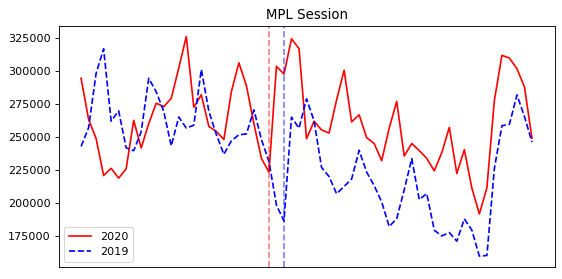

In [200]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4), dpi=80)
plt.plot(df_2020['Date'], df_2020['MPL'], '-', c='r', label='2020')
plt.plot(df_2019['dt'], df_2019['MPL'], '--', c='b',label='2019')
plt.title('MPL Session')
plt.axvline('11-26',c='r', linestyle='--',alpha=0.5)
plt.axvline('11-28',c='b', linestyle='--',alpha=0.5)
plt.legend()
plt.xticks([])
plt.show()

In [206]:
df_2020

,Date,PV,MPL,Session,cart_adds,xos,Sales,(GMV),axov,xo,per,mpl,session,Email
0,11-01,"209,685",294505,17961,2257,"$802,787",355.687532,0.77%,21228,NaN,NaN,NaN,NaN,NaN
1,11-02,"182,473",263310,16252,1957,"$757,374",387.007455,0.74%,901618,NaN,NaN,NaN,NaN,NaN
2,11-03,"171,880",248780,15658,1862,"$766,311",411.552777,0.75%,13546860,NaN,NaN,NaN,NaN,NaN
3,11-04,"148,468",220641,13905,1782,"$797,493",447.526813,0.81%,12631250,NaN,NaN,NaN,NaN,NaN
4,11-05,"151,183",226147,14191,1731,"$744,338",430.004760,0.77%,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,12-27,"228,170",311931,20761,2341,"$760,385",324.812230,0.75%,5,NaN,NaN,NaN,NaN,NaN
57,12-28,"222,481",309802,20187,2434,"$892,603",366.722605,0.79%,888172,NaN,NaN,NaN,NaN,NaN
58,12-29,"216,413",301728,19923,2357,"$865,230",367.089402,0.78%,13322509,NaN,NaN,NaN,NaN,NaN
59,12-30,"204,176",287928,18219,2438,"$875,560",359.130595,0.85%,12167203,NaN,NaN,NaN,NaN,NaN


In [207]:
df_2020['GMV'] = df_2020['xos'].apply(lambda x: int(x.replace(',','').replace('$',''))).astype('int')

In [201]:
df_2019['GMV'] = df_2019['Sales (GMV)'].apply(lambda x: int(x.replace(',','').replace('$',''))).astype('int')

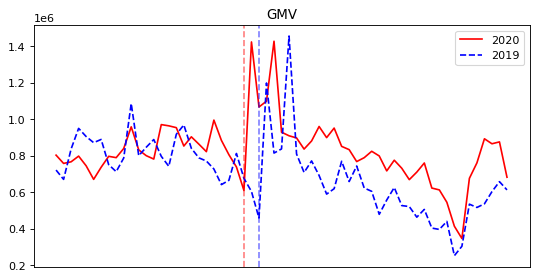

In [209]:
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(df_2020['Date'], df_2020['GMV'], '-', c='r', label='2020')
plt.plot(df_2019['dt'], df_2019['GMV'], '--', c='b',label='2019')
plt.title('GMV')
plt.axvline('11-26',c='r', linestyle='--',alpha=0.5)
plt.axvline('11-28',c='b', linestyle='--',alpha=0.5)
plt.legend()
plt.xticks([])
plt.show()

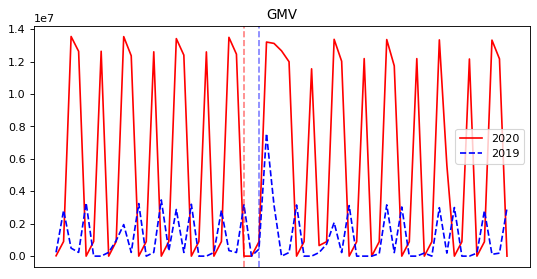

In [210]:
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(df_2020['Date'], df_2020['axov'], '-', c='r', label='2020')
plt.plot(df_2019['dt'], df_2019['Email'], '--', c='b',label='2019')
plt.title('GMV')
plt.axvline('11-26',c='r', linestyle='--',alpha=0.5)
plt.axvline('11-28',c='b', linestyle='--',alpha=0.5)
plt.legend()
plt.xticks([])
plt.show()

### Modeling